# Bayesian Logistic Regression for Breast Cancer Data Set
The setting for this experiment is a reconstruction of an experiment in the paper *Parallel MCMC with Generalized Elliptical Slice Sampling* (Nishihara et al. 2014). The likelihood is obtained by the usual logistic regression model for the 30-dimensional *breast cancer Wisconsin diagnostic data set*, as can be retrieved from [Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data), normalized so that each feature has sample mean zero and sample variance one. 

Denote the data set as $(a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}} \subset \mathbb{R}^d \times \{-1,1\}$, where $d = 31$, $n_{\text{data}} = 569$ and where have padded the data by $a^{(i)}_d := 1 \; \forall i$ to enable an intercept.
Our prior is the mean-zero Gaussian $\mathcal{N}_d(0, \sigma^2 I_d)$ with $\sigma^2 = 100$. The likelihood is obtained by the usual logistic regression model. Our target density, the (unnormalized) posterior density, is therefore given by
$$
\varrho(x)
= \mathcal{N}_d(x; 0, \sigma^2 I_d) \prod_{i=1}^{n_{\text{data}}} \frac{1}{1 + \exp(-b^{(i)} \langle a^{(i)}, x \rangle)} , 
\quad x \in \mathbb{R}^d .
$$

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
from generalized_elliptical_slice_sampling import two_group_gess
import stan_utils as su
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import time as tm
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/BLR_breast_cancer_"

### Retrieve and Prepare the Data, do Feature Engineering, Construct the Target Density

In [4]:
# load data set from file
data = pd.read_csv("../data/breast_cancer_wisconsin_diagnostic.csv")
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [5]:
# retrieve features, normalize them to mean zero and unit variance, append a unit feature to enable intercept
n_data = data.shape[0]
features = data.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1)
a = np.hstack([((features - features.mean()) / features.std()).to_numpy(), np.ones((n_data,1))])

In [6]:
# retrieve labels (B = benign, M = malignant), map them to +-1
labels = data['diagnosis'].to_numpy()
b = np.array(labels == 'M', dtype=int) - np.array(labels == 'B', dtype=int)

In [7]:
# set/retrieve some general parameters
d = a.shape[1]
sig_sq = 100 # prior variance

In [8]:
# construct posterior
def log_density(x):
    return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))

#### Special Treatment for Stan

In [9]:
stan_code = su.BLR_CODE
stan_data = su.blr_data(n_data, d, a, b, np.sqrt(sig_sq))

In [10]:
su.prevent_crashes(stan_code, stan_data)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (1/1)
Sampling: 100% (1/1), done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20


### Run the Samplers

In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

Note: If either PATT or GESS is run before HRUSS and AdaRWM, it can break the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [11]:
n_chains = 10 # number of parallel chains permitted to each sampler (except GESS)
n_its = int(1e5) # total number of iterations per chain, per sampler (except AdaRWM, GESS)
x_0s = rnd.normal(size=(n_chains,d)) # suggested initial states

#### Hit-and-Run Uniform Slice Sampling

In [12]:
w_hruss = 1.0

In [13]:
samples_hruss, tde_hruss, times_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 100000/100000 [00:28<00:00, 3551.52it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis
Note: We grant AdaRWM significantly more iterations than its competitors because it has a much lower computational cost per iteration (by virtue of only using one TDE per iteration) and we intend to grant the different samplers roughly the same computational budget.

In [14]:
n_its_rwm = 5 * n_its

In [15]:
samples_rwm, times_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 500000/500000 [00:59<00:00, 8435.79it/s]


Processing returns and terminating...


In [16]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

#### PATT Elliptical Slice Sampling

In [17]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [18]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [19]:
samples_ess = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_ess = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_ess = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [20]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = 1.0
w_att = np.sqrt(d) / 2

In [21]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [22]:
samples_gpss = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_gpss = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_gpss = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling
Note: We grant GESS significantly more iterations than is appropriate with regards to our intent to allocate each method roughly the same computational budget. This is necessitated by GESS's demand for a very large number of chains on the one hand, and our desire to properly analyze the autocorrelation of each of these chains on the other hand.

In [23]:
n_chains_gess = max(2*d, n_chains)
n_its_gess = int(2e4)
x_0s_gess = rnd.normal(size=(2*n_chains_gess,d))

In [24]:
time_b = tm.time()
ret_dic = two_group_gess(log_density, n_chains_gess, 2 * n_its_gess, x_0s_gess, n_thr=n_chains)
time_a = tm.time()
total_time_gess = time_a - time_b

Checking validity of given arguments...
Preparing for parallel sampling...
Starting two-group sampling...


  0%|          | 0/40002 [00:00<?, ?it/s]

Assembling output...


In [25]:
samples_gess = ret_dic['samples']
tde_gess = ret_dic['tde_cnts']
schedule_gess = ret_dic['schedule']
dfs_G1, dfs_G2 = ret_dic['dfs']
centers_G1, centers_G2 = ret_dic['centers']
centers_gess = np.concatenate([centers_G1.reshape(-1,1,d), centers_G2.reshape(-1,1,d)], axis=1)
scale_G1, scale_G2 = ret_dic['scales']

#### Stan's NUTS

In [26]:
time_b = tm.time()
frames_stan, samples_stan, tge_stan, acc_rates_stan \
= su.sample_in_parallel(stan_code, stan_data, n_chains, n_its, x_0s)
time_a = tm.time()
total_time_stan = time_a - time_b

Building: found in cache, done.
Building: found in cache, done.
Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Messages from stanc:
Sampling:   0%
Sampling:   0%
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Messages fr

Sampling:  45% (45700/101000)
Sampling:  46% (46800/101000)
Sampling:  49% (49700/101000)
Sampling:  49% (49800/101000)
Sampling:  50% (50100/101000)
Sampling:  52% (52200/101000)
Sampling:  61% (62000/101000)
Sampling:  63% (64000/101000)
Sampling:  72% (72500/101000)
Sampling:  67% (67900/101000)
Sampling:  59% (59200/101000)
Sampling:  68% (69000/101000)
Sampling:  61% (61200/101000)
Sampling:  61% (61600/101000)
Sampling:  72% (72800/101000)
Sampling:  65% (65400/101000)
Sampling:  65% (66100/101000)
Sampling:  82% (82400/101000)
Sampling:  83% (83400/101000)
Sampling: 100% (101000/101000)
Sampling: 100% (101000/101000), done.
Messages received during sampling:
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
Sampling:  73% (74100/101000)
Sampling:  74% (74400/101000)
Sampling: 100% (101000/101000)
Sampling: 100% (101000/101000)
Sampling: 100% (101000/101000), done.


In [27]:
frames_stan[0]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,x.1,x.2,x.3,...,x.22,x.23,x.24,x.25,x.26,x.27,x.28,x.29,x.30,x.31
draws,,,,,,,,,,,,,,,,,,,,,
0,-39.091369,0.994663,0.042538,6.0,63.0,0.0,51.243273,-14.203790,1.942277,-8.635236,...,5.547816,10.127132,10.430542,-1.902018,-0.655723,5.344208,-0.487409,9.184764,5.819187,4.220851
1,-41.289009,0.890949,0.042538,7.0,127.0,0.0,50.649209,-14.111368,2.803857,1.255390,...,4.511659,-2.440467,4.232817,-0.781295,1.207873,4.377075,0.346684,8.660461,5.137435,5.176838
2,-32.436141,0.961414,0.042538,7.0,127.0,0.0,59.480881,6.585870,-0.885641,-7.694829,...,7.512845,3.201658,11.221604,1.356916,-7.753160,5.041386,4.765341,3.385023,8.783046,3.212802
3,-28.772146,0.751037,0.042538,7.0,127.0,0.0,45.250020,-9.804526,-1.308853,2.591585,...,4.877583,9.217358,1.764841,-0.018281,-6.209094,1.950035,2.608149,1.322206,3.931636,0.418067
4,-39.385790,0.885420,0.042538,7.0,127.0,0.0,51.556612,-17.139477,1.705234,-4.440667,...,5.227718,2.375604,5.822538,-2.609046,-1.695060,6.709235,1.377536,6.508970,9.136654,3.704865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-31.638861,0.845712,0.042538,7.0,127.0,0.0,50.370561,-5.094120,1.418904,0.207689,...,4.553553,1.732612,9.706733,-1.429732,-10.074759,6.232967,-0.993069,4.672784,8.977060,2.226588
99996,-31.317021,0.842105,0.042538,7.0,127.0,0.0,45.927780,-7.429077,2.174828,1.486033,...,1.811678,-0.382357,1.096245,-0.715062,-5.264584,5.144630,3.248521,5.061037,6.115481,2.084662
99997,-35.455508,0.836313,0.042538,7.0,127.0,0.0,45.903137,-1.254028,-2.872556,-4.999035,...,9.755175,1.990504,11.887471,-3.067298,-2.995028,7.068992,1.925157,4.597600,10.218923,4.725094


### Analyze Sampling Performance

In [28]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "GESS", "Stan's NUTS"]
nsam = len(snames)
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_gess, samples_stan]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tde_gess, tge_stan]
full_times = [times_ess, times_gpss, times_hruss, times_rwm, None, None] # this list...
full_total_times = [None, None, None, None, total_time_gess, total_time_stan] # ...should complement this list
n_chains_all = np.full(nsam, n_chains)
n_chains_all[4] = n_chains_gess # make sure index 4 <-> GESS!
n_its_all = np.array([n_its, n_its, n_its, n_its_rwm, n_its_gess, n_its], dtype=int)
n_burns = n_its_all // 2
n_late_its = n_its_all - n_burns
n_late_samples = n_chains_all * n_late_its

In [29]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
burn_times = [ft[:nb] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
times = [ft[nb:] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)
pos_mean_ests = [np.mean(sams, axis=(0,1)) for sams in samples]

In [30]:
# collect total runtimes taken by each sampler for the "late" iterations
total_times = np.zeros(nsam)
for i in range(nsam):
    if type(times[i]) != type(None):
        total_times[i] = np.mean(np.sum(times[i], axis=0))
    else:
        total_times[i] = full_total_times[i] * (n_late_its[i] / n_its_all[i])

In [31]:
# the IAT computation in this cell likely takes a few minutes
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
sams_per_s = n_late_samples / total_times
maxls = [1000, 1000, int(1e4), 2500, 1000, 1000]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT
accuracy = lambda coef: np.mean(np.sign(np.inner(a, coef)) == b)
accuracies = [accuracy(pme) for pme in pos_mean_ests]

In [32]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.array(sams_per_s, dtype=int),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2),
        np.round(es_per_s, 2),
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
        np.round(accuracies, 3),
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
        "Accuracy",
    ]
)

,Sampler,Burn-In TDE/it,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS,Accuracy
0,PATT-ESS,4.51,3.45,18665,12.56,14.93,43.38,1485.76,0.23,0.988
1,PATT-GPSS,12.41,8.28,15365,8.66,15.94,71.74,1773.74,0.52,0.988
2,HRUSS,5.7,5.69,40322,2968.41,0.73,16893.87,13.58,7.81,0.988
3,AdaRWM,1.0,1.0,87359,150.95,1.86,150.95,578.72,0.54,0.988
4,GESS,5.29,5.25,12431,109.07,5.01,572.34,113.97,1.05,0.988
5,Stan's NUTS,131.71,131.85,2829,1.33,34.97,175.27,2128.92,3.77,0.988


### Plotting

In [33]:
n_win = int(1e4)

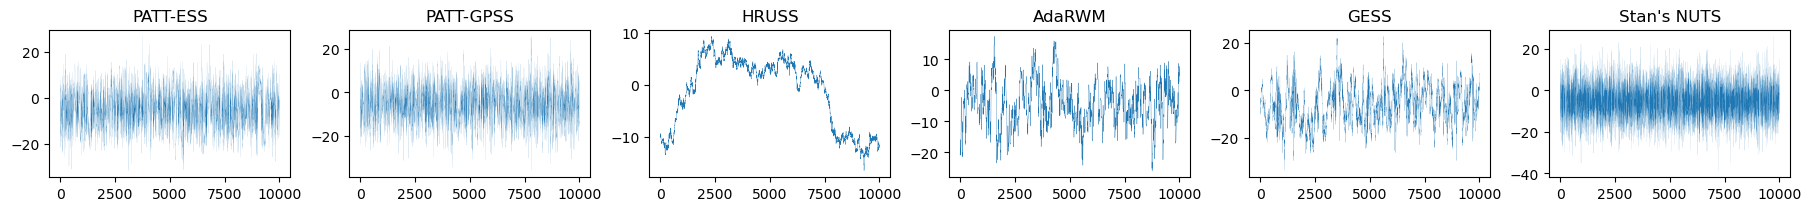

In [34]:
lws = [0.05, 0.05, 0.25, 0.25, 0.1, 0.05]
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

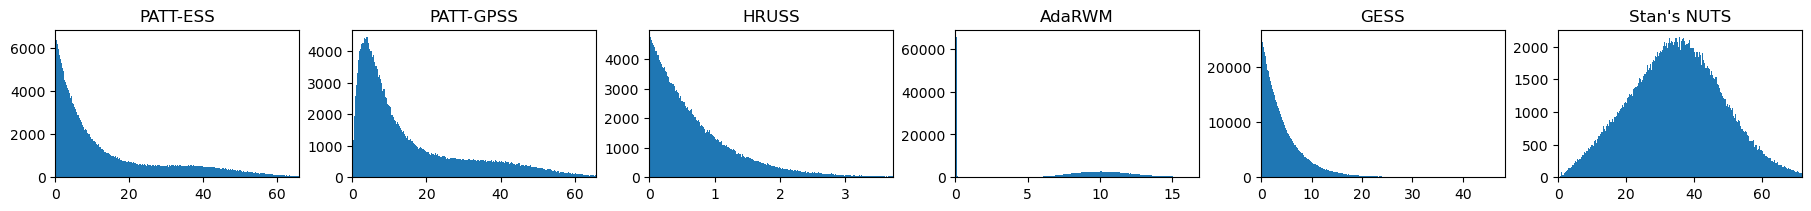

In [35]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[3] = plot_steps[3][plot_steps[3] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

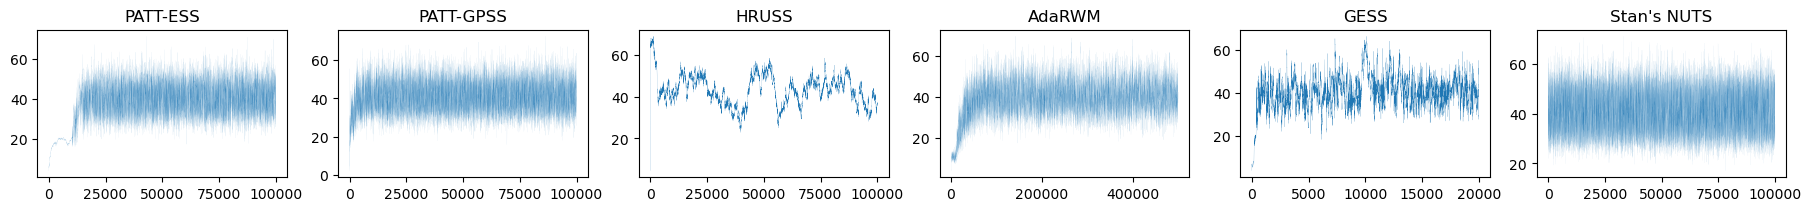

In [36]:
lws = [0.025, 0.025, 0.1, 0.025, 0.1, 0.025]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

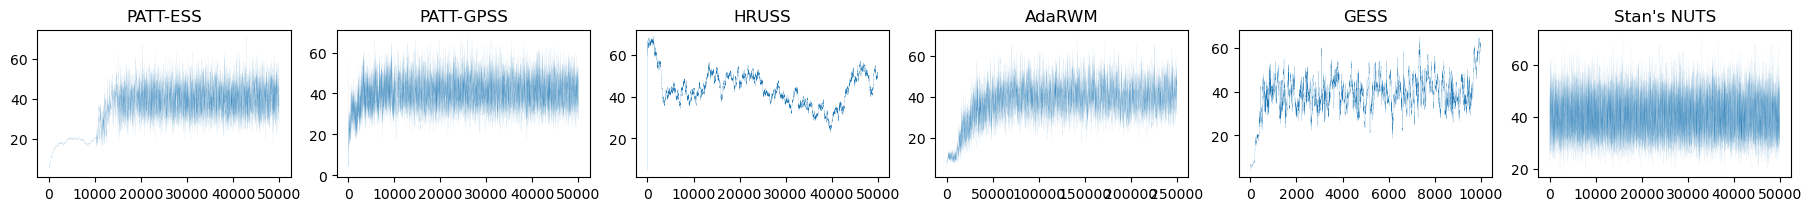

In [37]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

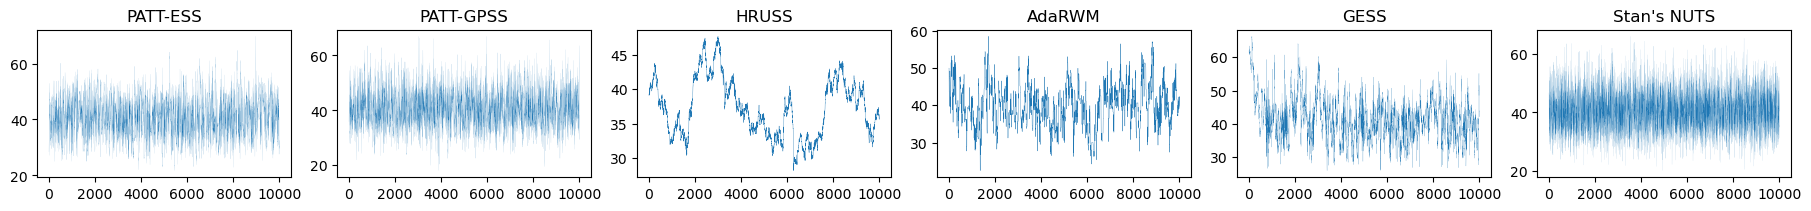

In [38]:
lws = [0.05, 0.05, 0.25, 0.25, 0.1, 0.05]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

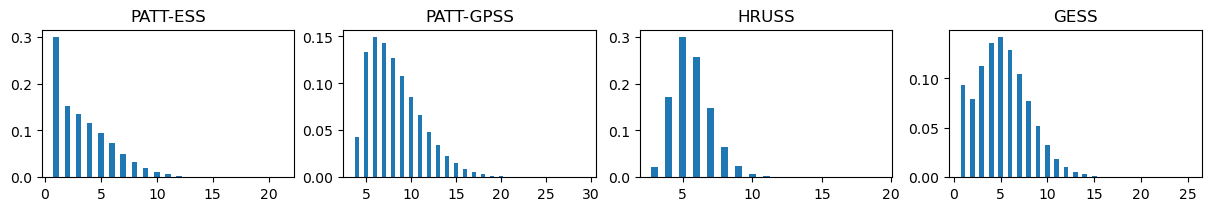

In [39]:
tde_inds = [0,1,2,4]
pfs.plot_tde_distr_row([tde[i] for i in tde_inds], [snames[i] for i in tde_inds])

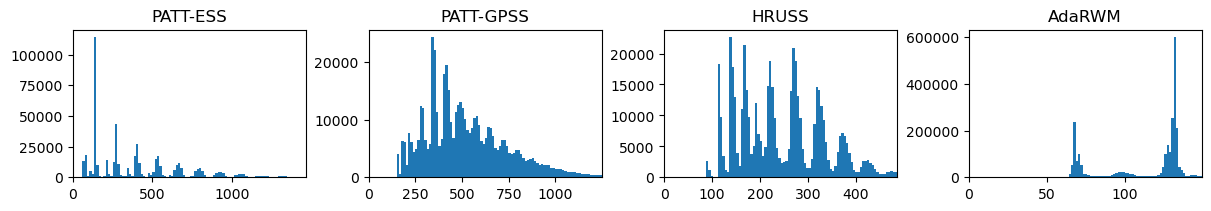

In [40]:
granular_times = [0,1,2,3]
pfs.plot_runtime_hist_row([times[i] for i in granular_times], 
                          [snames[i] for i in granular_times], nbins=100, cutoff_quant=0.99)

In [41]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.225
Minimal AdaRWM acceptance rate: 0.220
Maximal AdaRWM acceptance rate: 0.228


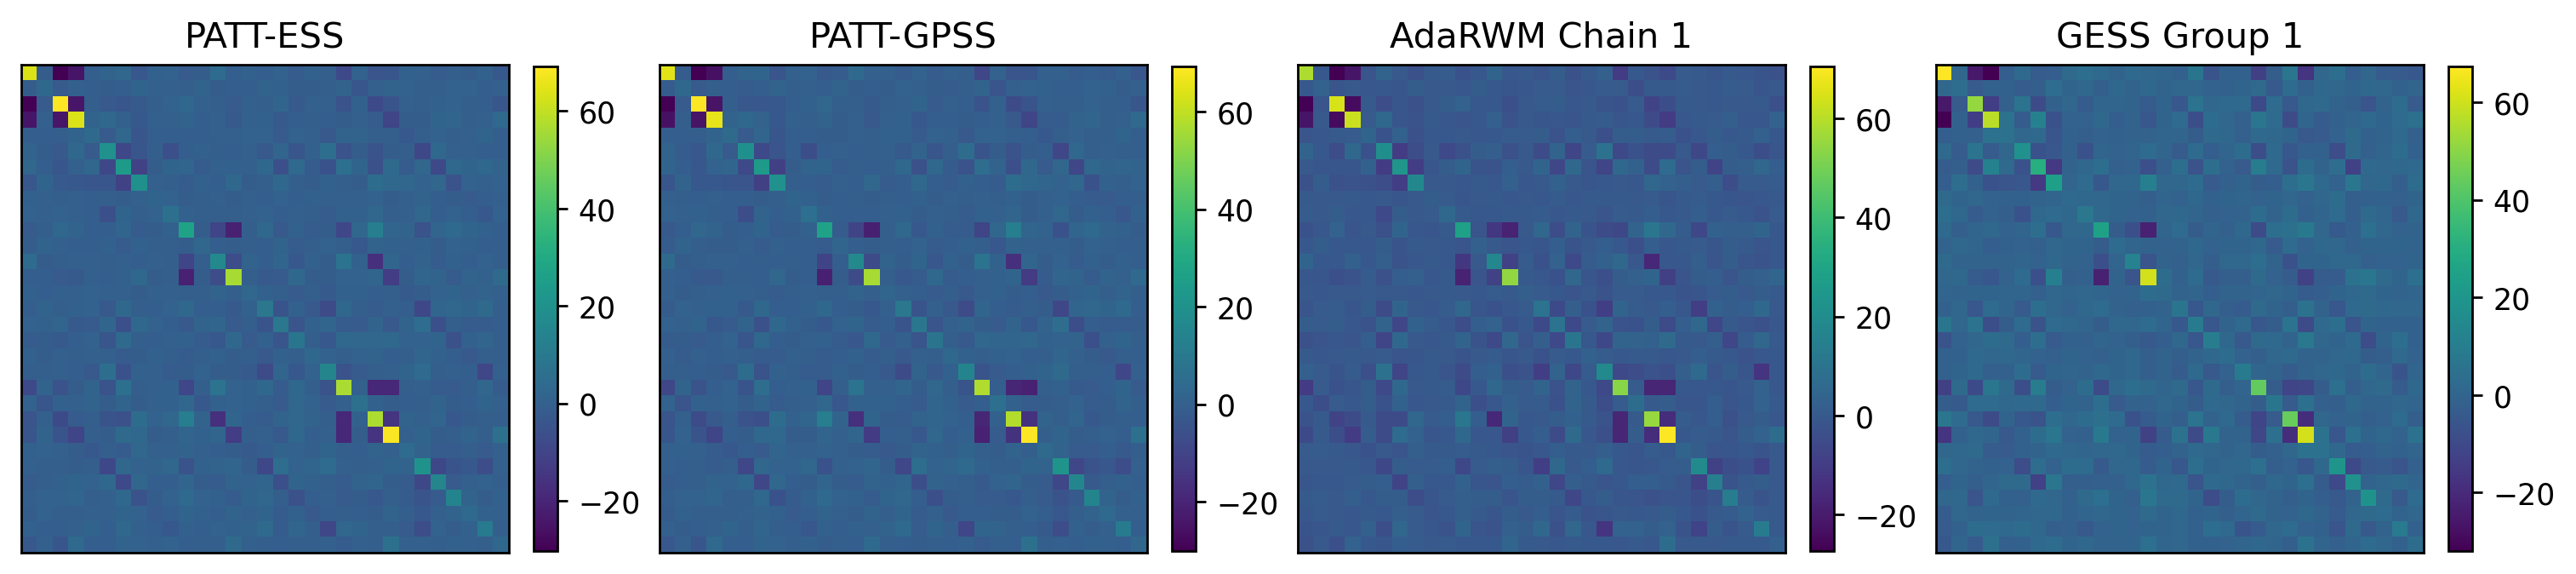

In [42]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "GESS Group 1"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], scale_G1]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path, shrink=0.78)

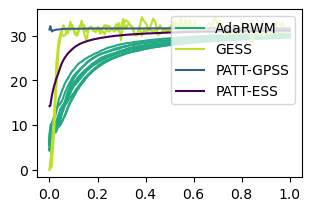

In [43]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
norms_rwm = mcu.get_radii(means_rwm)
norms_gess = mcu.get_radii(centers_gess)
colors = plt.cm.viridis(np.linspace(0, 0.9, 4))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,0], color=colors[3], label=snames[4])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,1], color=colors[3])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

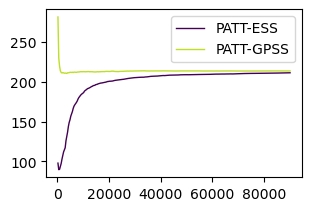

In [44]:
# plot progressions of the norm of the PATT samplers' posterior covariance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(schedule_ess.shape[0],-1))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(schedule_gpss.shape[0],-1))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

In [45]:
# I would plot the dfs used by GESS, but...
print(np.unique(dfs_G1[1:]))
print(np.unique(dfs_G2[1:]))

[1000000.]
[1000000.]


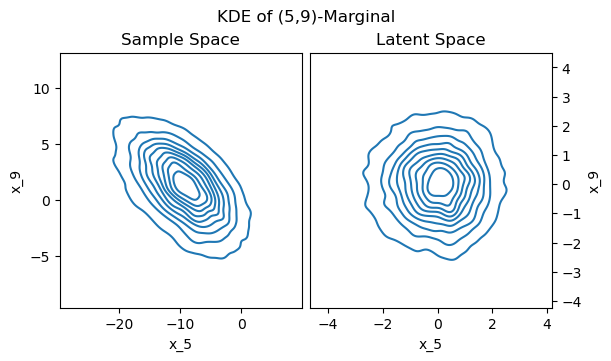

In [46]:
# plot a bivariate marginal KDE in sample space and (PATT-ESS's final) latent space
inds = [5,9]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[0][:,0,inds[0]].reshape(-1,1),
                                samples[0][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
L = np.linalg.cholesky(covs_gpss[-1])
L_inv = np.linalg.inv(L)
alpha_inv = lambda y: L_inv @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[0][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

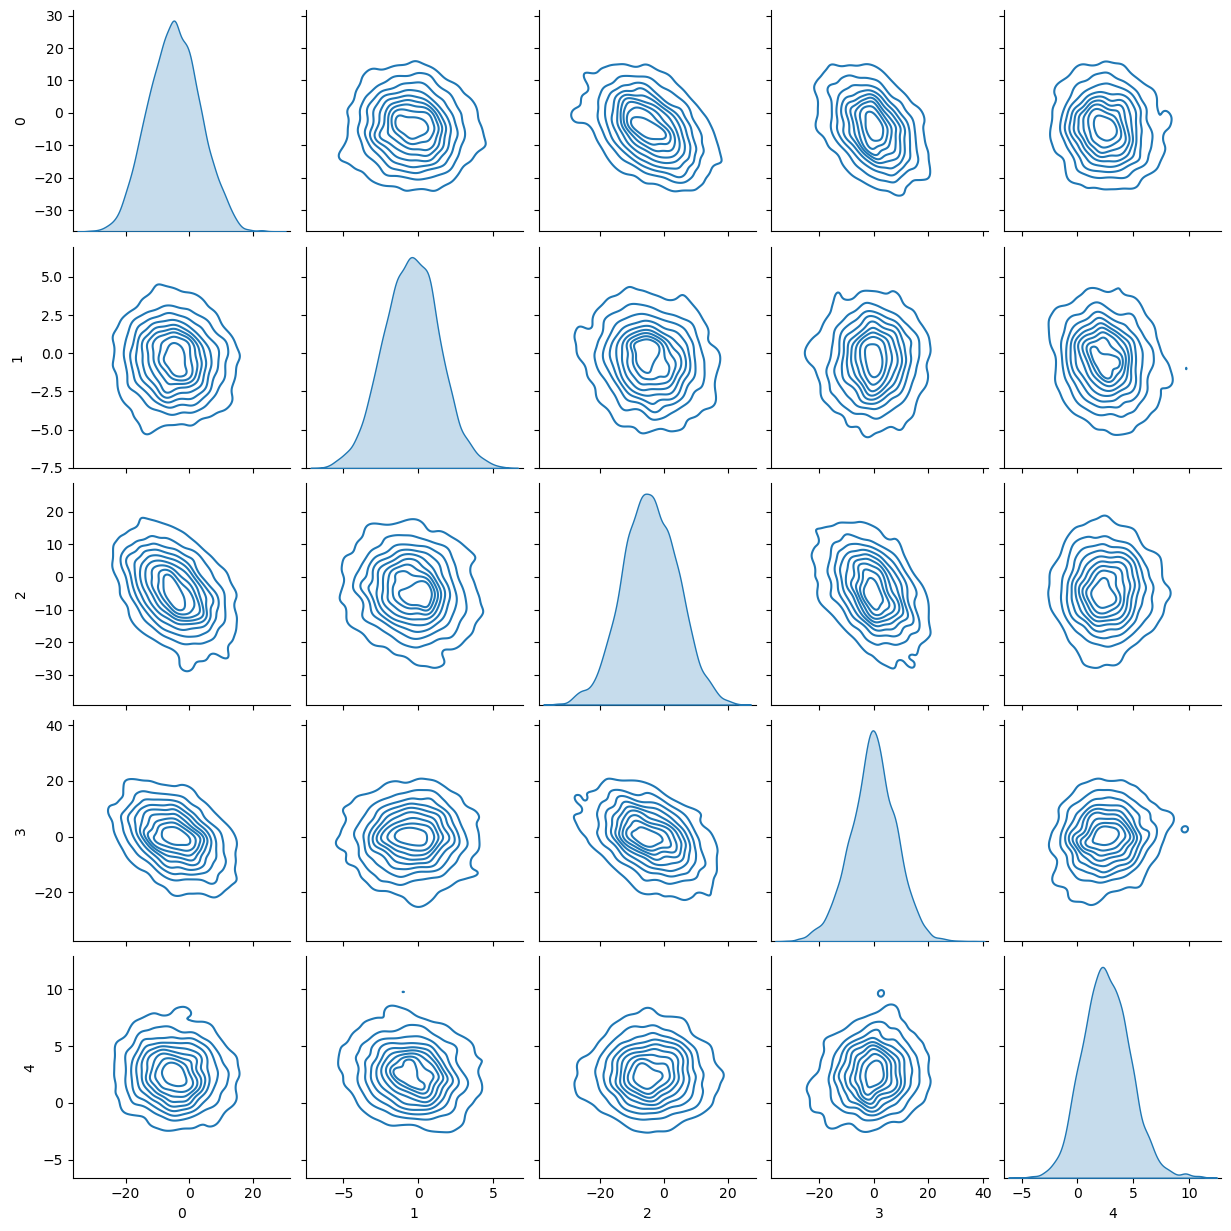

In [47]:
# this cell may take a few minutes to run
sb.pairplot(pd.DataFrame(samples[0][-n_win:,0,:5]), kind='kde')
plt.show()

In [48]:
pos_mean_ests[0]

array([-5.29177144, -0.36800439, -4.06336281, -0.24337729,  2.45562882,
       -9.43091983,  9.18558885,  4.30693707, -1.59103561,  1.28819062,
        6.25610291, -2.61904548, -3.19204119, 11.68981099,  1.89094365,
        4.06467443, -7.09576944,  6.40733069, -2.06542671, -9.46105341,
        7.85879147,  6.70437134,  5.17968172, 10.41940811, -0.82630878,
       -4.11989904,  4.50925343,  1.90276883,  4.18741954,  6.53074946,
        3.29424821])